In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

C:\Users\LucasMagalhaes\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
filepath = "C:/Users/LucasMagalhaes/Documents/Projects/ML/Stock_predixtion/Tests/"
filepath

'C:/Users/LucasMagalhaes/Documents/Projects/ML/Stock_predixtion/Tests/'

In [3]:
def add_boulinger_bands(df):
    middle_band = []
    upper_band = []
    lower_band = []

    for i in range(20, df.shape[0]+1):

        lst_num = df['Adj_Close'][(i-20):i].tolist()
        _mid_band = sum(lst_num)/20
        std = math.sqrt(sum([math.pow((x-_mid_band),2) for x in lst_num])/20)
        _upper_band = _mid_band + (2*std)
        _lower_band = _mid_band - (2*std)

        if i == 20:
            middle_band = [_mid_band for x in range(20)]
            upper_band = [_upper_band for x in range(20)]
            lower_band = [_lower_band for x in range(20)]
        else:
            middle_band.append(_mid_band)
            upper_band.append(_upper_band)
            lower_band.append(_lower_band)

    df['Middle_Band'] = middle_band
    df['Upper_Band'] = upper_band
    df['Lower_Band'] = lower_band
    df['Lower_Upper_Diff'] = df['Upper_Band'] - df['Lower_Band']
    df['Upper_Price_Diff'] = df['Upper_Band'] - df['Adj_Close']
    df['Price_Lower_Diff'] = df['Adj_Close'] - df['Lower_Band']

    return df

In [4]:
def add_RSI(df):
    rsi = []

    av_gain = 0
    av_loss = 0

    for i in range(15, df.shape[0]+1):
        lst_num = df['Adj_Close'][(i-15):i].tolist()
        lst_change = [lst_num[x+1] - lst_num[x] for x in range(len(lst_num)-1)]

        if i == 15:
            _av_gains = sum([x for x in lst_change if x > 0])/14
            _av_loss = -1*sum(list(filter(lambda x: x < 0, lst_change)))/14

            if _av_loss == 0:
                _rsi = 100
            else:
                rs = _av_gains/_av_loss
                _rsi = 100 - (100/(1+rs))

            av_gain = _av_gains
            av_loss = _av_loss

            rsi = [_rsi for x in range(15)]

        else:
            curr_gain = lambda x: x if x > 0 else 0
            curr_loss = lambda x: abs(x) if x < 0 else 0

            _av_gains = ((av_gain*13)+curr_gain(lst_change[(len(lst_change)-1)]))/14
            _av_loss = ((av_loss*13)+curr_loss(lst_change[(len(lst_change)-1)]))/14
            
            if _av_loss == 0:
                _rsi = 100
            else:
                rs = _av_gains/_av_loss
                _rsi = 100 - (100/(1+rs))

            av_gain = _av_gains
            av_loss = _av_loss
            rsi.append(_rsi)

    df['RSI'] = rsi
    
    return df

In [5]:
def moving_averages_MACD(df):
    #26 ema line
    two_six_ema = [0 for i in range(25)]
    #12 ema line
    one_two_ema = [0 for i in range(11)]
    #signal line is a 9 day ema line
    signal_ema = [0 for i in range(33)]
    #macd line
    macd_line = [0 for i in range(25)]
    #simple 50 day moving average
    fifty_ma = [0 for i in range(49)]
    #simple 200 day moving average
    two_hondo_ma = [0 for i in range(199)]

    #Turning the price column into list for ease of use
    lst_num = df['Adj_Close'].tolist()

    _12_day_ema = 0
    _26_day_ema = 0
    _9_day_ema = 0
    for i in range(len(lst_num)):
        """
        12 DAY EXPONENTIAL MOVING AVERAGE
        """
        if i >= 11:
            if i == 11:
                _12_day_ema = sum(lst_num[0:i+1])/12
            else:
                c = 2/13
                _12_day_ema = (lst_num[i]-_12_day_ema)*c + _12_day_ema

            one_two_ema.append(_12_day_ema)

        """
        26 DAY EXPONENTIAL MOVING AVERAGE
        """
        if i >= 25:
            if i == 25:
                _26_day_ema = sum(lst_num[0:i+1])/26
            else:
                c = 2/27
                _26_day_ema = (lst_num[i]-_26_day_ema)*c + _26_day_ema

            two_six_ema.append(_26_day_ema)

        """
        MACD LINE
        """
        if i >= 25:
            macd_line.append(one_two_ema[i] - two_six_ema[i])

        """
        9 DAY EXPONENTIAL MOVING AVERAGE - SIGNAL LINE
        """
        if i >= 33:
            if i == 33:
                _9_day_ema = sum(macd_line[i-9:i+1])/9
            else:
                c = 2/10
                _9_day_ema = (macd_line[i]-_9_day_ema)*c + _9_day_ema

            signal_ema.append(_9_day_ema)

        """
        50 DAY SIMPLE MOVING AVERAGE
        """
        if i >= 49:
            _50_day_sma = sum(lst_num[i-49:i+1])/50

            fifty_ma.append(_50_day_sma)           

        """
        200 DAY SIMPLE MOVING AVERAGE
        """
        if i >= 199:
            _200_day_sma = sum(lst_num[i-199:i+1])/200
        
            two_hondo_ma.append(_200_day_sma)

    df['MACD_Line'] = macd_line 
    df['Signal_Line'] = signal_ema
    df['MACD_Diff'] = df['MACD_Line'] - df['Signal_Line']
    df['200_day_SMA'] = two_hondo_ma
    df['50_day_SMA'] = fifty_ma
    
    return df

In [6]:
def create_data_sets(df, scaler_type='min_max_scaler'):
    #Copy dataframe to a new dataframe that will be manipulated
    df_stock = df.copy()
    #drop useless columns, keep all indicators plus Adj CLose and Adj Volume
    df_stock.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Volume',
                    'Dividend', 'Split', 'Adj_Open', 'Adj_High', 'Adj_Low'], 1, inplace=True)
    #Need to get rid of the first 200 rows so all indicators will have their true values intead of zeros
    df_stock = df_stock.iloc[199:, :]
    
    #print(df_stock.head())
    #print(df_stock.tail())
    
    #Test set will be 20% of data
    test_set_size = math.floor(df_stock.shape[0]*.2)
    #Train set size will be the total set minus test set
    train_set_size = df_stock.shape[0] - test_set_size
    #Need to scale the data
    all_data = scaler(df_stock, scaler_type=scaler_type)
    
    if all_data is not None:
        #Seperate Data between training and testing
        train_data = all_data[:train_set_size, :]
        test_data = all_data[train_set_size:, :]
        
        #Return train and test data
        return train_data, test_data
    else:
        return None

In [7]:
def scaler(df, scaler_type, smoothing_size='365'):
    
    """
    Min Max Scaler will scale all features to fit between -1 and 1,
    it uses a sliding window, that will prevent early stock prices
    to be useless since they would get even smaller.
    The default value of the sliding window is 365 (a year)
    """
    if scaler_type == 'min_max_scaler':
        #Turn dataFrame into numpy array
        all_data = df.values
        scaler = MinMaxScaler()
        smoothing_window_size = 365
        for di in range(0,((all_data.shape[0]//smoothing_window_size)*smoothing_window_size), smoothing_window_size):
            scaler.fit(all_data[di:di+smoothing_window_size])
            all_data[di:di+smoothing_window_size, :] = scaler.transform(all_data[di:di+smoothing_window_size, :])

        scaler.fit(all_data[di+smoothing_window_size:])
        all_data[di+smoothing_window_size:, :] = scaler.transform(all_data[di+smoothing_window_size:, :])
        
        return all_data
    """
    Percent change scaler, will scale the:
    #Name, Index
    - Adj_Close
    - 200_day_SMA
    - 50_day_SMA
    - Middle_Band
    - Lower_Band
    - Upper_Band
    
    The rest of the features are small and have low variance
    It will change the values based on percent change from
    previous value
    """    
    if scaler_type == 'percent_change':
        #Turn dataFrame into numpy array
        all_data = df.values
        #list of columns to be scaled
        cols = ['Adj_Close','200_day_SMA','50_day_SMA','Middle_Band',
               'Lower_Band','Upper_Band']
        #Get index of the columns to be scaled
        cols_i = [df.columns.get_loc(i) for i in cols]
        
        #Loop throgh all rows and scale them
        for di in range(1, all_data.shape[0]):
            for col in cols_i:
                all_data[di,col] = (all_data[di,col]-df.iloc[di-1,col])/df.iloc[di-1,col]
            
        return all_data
    
    """
    High Low Day scaler will change the feature values for negative percent
    change to -1 and feature values with positive percent change from previous
    value to 1. This will only work on the features:
    - Adj_Close
    - 200_day_SMA
    - 50_day_SMA
    
    I am also going to drop:
    - Middle_Band
    - Lower_Band
    - Upper_Band
    """    
    if scaler_type == 'high_low_day':
        #Throw away columns not used
        cols_throw = ['Middle_Band','Lower_Band','Upper_Band']
        df = df.drop(cols_throw, 1)
        
        #Columns to be scaled
        cols = ['Adj_Close','200_day_SMA','50_day_SMA']
        cols_i = cols_i = [df.columns.get_loc(i) for i in cols]
        
        #Turn dataFrame into numpy array
        all_data = df.values
        #print(all_data.shape)
        
        chg = 0
        for di in range(1, all_data.shape[0]):
            for col in cols_i:
                chg = (all_data[di,col]-df.iloc[di-1,col])/df.iloc[di-1,col]
                if chg >= 0:
                    all_data[di,col] = 1
                else:
                    all_data[di,col] = -1
    
        return all_data
        
    return None
        

In [16]:
def create_batch_generator(x, num_unroll, batch_size):
    #Create empty numpy arrays that will generate the data in the correct format
    unrolled_x = np.zeros(shape=(batch_size, x.shape[1], num_unroll))
    unrolled_y = np.zeros(shape=(batch_size, 1, num_unroll))
    batches_x = np.zeros(shape=(batch_size, x.shape[1], num_unroll))
    #Number of unrolled batches that can be created without stepping over the end
    n_unrolled_batches = len(x)//(batch_size)
    #print(x.shape)
    #Cut off ends that do not have enough data samples to make a unrolled batch
    #print(n_unrolled_batches%num_unroll)
    x = x[:((n_unrolled_batches-(n_unrolled_batches%num_unroll))*batch_size)]
    #print(x.shape)

    #Generate data
    batches_x = np.zeros(shape=(batch_size, x.shape[1], n_unrolled_batches))
    min_x = 0
    max_x = min_x + batch_size
    for i in range((n_unrolled_batches-(n_unrolled_batches%num_unroll))):
        batches_x[:,:,i] = x[min_x:max_x,:]
        min_x = max_x
        max_x += batch_size
    print(batches_x.shape)
    for i in range(batches_x.shape[2]-num_unroll-1):
        unrolled_x = batches_x[:,:,i:i+num_unroll]
        unrolled_y = batches_x[:,0,i+num_unroll+1]
        yield unrolled_x, unrolled_y

In [27]:
"""APPLE"""
#Acquire data from CSV
aapl = pd.read_csv(filepath+'EOD-AAPL.csv')
#Values need to be reindexed from bottom to top
#so earlier values are on top of the dataframe
aapl = aapl.iloc[::-1]
#Reset the index, and get rid of old index
aapl = aapl.reset_index(drop=True)

#Add indicators to the dataframe
aapl = add_RSI(aapl)
aapl = add_boulinger_bands(aapl)
aapl = moving_averages_MACD(aapl)

#Get the train and test *preprocessed* data
aapl_train, aapl_test = create_data_sets(aapl)

print(aapl_train[1:6])
#print(aapl_test[aapl_test.shape[0]-5:])



[[1.14462699e-01 6.88058850e-02 1.83853224e-01 1.66059567e-01
  2.42350362e-01 9.66934569e-02 3.91116213e-01 9.48145740e-01
  1.15615786e-01 3.57777834e-03 6.94865792e-03 3.65604637e-01
  9.93299517e-01 3.01722879e-01]
 [1.14462699e-01 8.45646522e-02 1.83853224e-01 1.56111298e-01
  2.26724170e-01 9.32882808e-02 3.67496845e-01 8.89644094e-01
  1.21106098e-01 1.02418947e-02 0.00000000e+00 4.05220184e-01
  9.87343531e-01 2.94995887e-01]
 [1.48128198e-01 6.17984653e-02 3.51152548e-01 1.49805626e-01
  2.14623734e-01 9.35798732e-02 3.44276499e-01 7.09865871e-01
  1.85252870e-01 3.87564249e-02 6.69083647e-04 4.90071266e-01
  9.83000625e-01 2.90283149e-01]
 [1.61594398e-01 5.90398884e-02 4.07666642e-01 1.44632526e-01
  2.02699330e-01 9.60475847e-02 3.17723175e-01 6.11432505e-01
  2.07120839e-01 7.23603011e-02 8.54395162e-03 5.70333716e-01
  9.78598160e-01 2.85478155e-01]
 [1.58362510e-01 3.81761684e-02 3.97165547e-01 1.40239983e-01
  1.93243224e-01 9.73964686e-02 2.97689914e-01 5.88940281e-01


In [28]:
"""MICROSOFT"""
#Acquire data from CSV
msft = pd.read_csv(filepath+'EOD-MSFT.csv')
#Values need to be reindexed from bottom to top
#so earlier values are on top of the dataframe
msft = msft.iloc[::-1]
#Reset the index, and get rid of old index
msft = msft.reset_index(drop=True)

#Add indicators to the dataframe
msft = add_RSI(msft)
msft = add_boulinger_bands(msft)
msft = moving_averages_MACD(msft)

#Get the train and test *preprocessed* data
msft_train, msft_test = create_data_sets(msft)

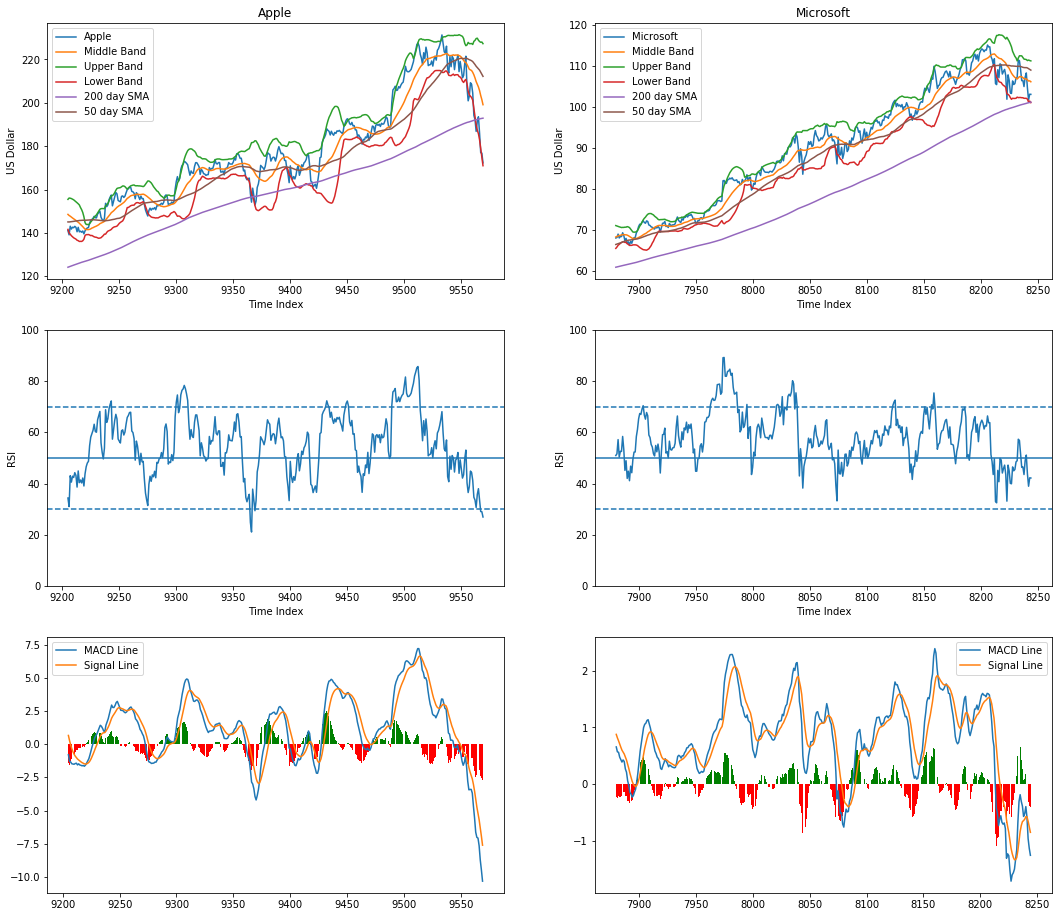

In [11]:
plt.figure(figsize=(18, 16))

time_step = 365


plt.subplot(321)
plt.title("Apple")
plt.plot(aapl.index[(aapl.shape[0]-time_step):], aapl['Adj_Close'][(aapl.shape[0]-time_step):], label="Apple")
plt.plot(aapl.index[(aapl.shape[0]-time_step):], aapl['Middle_Band'][(aapl.shape[0]-time_step):], label="Middle Band")
plt.plot(aapl.index[(aapl.shape[0]-time_step):], aapl['Upper_Band'][(aapl.shape[0]-time_step):], label="Upper Band")
plt.plot(aapl.index[(aapl.shape[0]-time_step):], aapl['Lower_Band'][(aapl.shape[0]-time_step):], label="Lower Band")
plt.plot(aapl.index[(aapl.shape[0]-time_step):], aapl['200_day_SMA'][(aapl.shape[0]-time_step):], label="200 day SMA")
plt.plot(aapl.index[(aapl.shape[0]-time_step):], aapl['50_day_SMA'][(aapl.shape[0]-time_step):], label="50 day SMA")
plt.ylabel("US Dollar")
plt.xlabel("Time Index")
plt.legend()

plt.subplot(322)
plt.title("Microsoft")
plt.plot(msft.index[(msft.shape[0]-time_step):], msft['Adj_Close'][(msft.shape[0]-time_step):], label="Microsoft")
plt.plot(msft.index[(msft.shape[0]-time_step):], msft['Middle_Band'][(msft.shape[0]-time_step):], label="Middle Band")
plt.plot(msft.index[(msft.shape[0]-time_step):], msft['Upper_Band'][(msft.shape[0]-time_step):], label="Upper Band")
plt.plot(msft.index[(msft.shape[0]-time_step):], msft['Lower_Band'][(msft.shape[0]-time_step):], label="Lower Band")
plt.plot(msft.index[(msft.shape[0]-time_step):], msft['200_day_SMA'][(msft.shape[0]-time_step):], label="200 day SMA")
plt.plot(msft.index[(msft.shape[0]-time_step):], msft['50_day_SMA'][(msft.shape[0]-time_step):], label="50 day SMA")
plt.ylabel("US Dollar")
plt.xlabel("Time Index")
plt.legend()

plt.subplot(323)
plt.plot(aapl.index[(aapl.shape[0]-time_step):], aapl['RSI'][(aapl.shape[0]-time_step):], label="Apple")
plt.ylabel("RSI")
plt.xlabel("Time Index")
plt.axhline(70, ls='--')
plt.axhline(30, ls='--')
plt.axhline(50, ls='-')
plt.ylim([0,100])

plt.subplot(324)
plt.plot(msft.index[(msft.shape[0]-time_step):], msft['RSI'][(msft.shape[0]-time_step):], label="Microsoft")
plt.ylabel("RSI")
plt.xlabel("Time Index")
plt.axhline(70, ls='--')
plt.axhline(30, ls='--')
plt.axhline(50, ls='-')
plt.ylim([0,100])

plt.subplot(325)
plt.plot(aapl.index[(aapl.shape[0]-time_step):], aapl['MACD_Line'][(aapl.shape[0]-time_step):], label="MACD Line")
plt.plot(aapl.index[(aapl.shape[0]-time_step):], aapl['Signal_Line'][(aapl.shape[0]-time_step):], label="Signal Line")
plt.bar(aapl.index[(aapl.shape[0]-time_step):], aapl['MACD_Diff'][(aapl.shape[0]-time_step):], color = ['r' if x < 0 else 'g' for x in aapl['MACD_Diff'][(aapl.shape[0]-time_step):].tolist()])
plt.legend()

plt.subplot(326)
plt.plot(msft.index[(msft.shape[0]-time_step):], msft['MACD_Line'][(msft.shape[0]-time_step):], label="MACD Line")
plt.plot(msft.index[(msft.shape[0]-time_step):], msft['Signal_Line'][(msft.shape[0]-time_step):], label="Signal Line")
plt.bar(msft.index[(msft.shape[0]-time_step):], msft['MACD_Diff'][(msft.shape[0]-time_step):], color = ['r' if x < 0 else 'g' for x in msft['MACD_Diff'][(msft.shape[0]-time_step):].tolist()])
plt.legend()

plt.show()

In [23]:
class LSTMStockPredictor():

    def __init__(self, data_dim, lstm_size=[128], batch_size=10, num_unrollings=10, learning_rate=0.01, 
                learning_rate_decay=0.99, init_epoch_decay=5):
        
        #numer of hidden units in the LSTM cell
        self.lstm_size = lstm_size
        #number of layers in the LSTM network
        self.num_layers = len(lstm_size)
        #batch size
        self.batch_size = batch_size
        #number of sequential data that will be used to train model
        self.num_unrollings = num_unrollings
        #dimension of data
        self.data_dim = data_dim
        #learning rate
        self.learning_rate = learning_rate
        #Learning rate decay
        self.learning_rate_decay = learning_rate_decay
        #First epoch to start the decay of the learning rate
        self.init_epoch_decay = init_epoch_decay

        self.g = tf.Graph()
        with self.g.as_default():
            tf.set_random_seed(123)
            self.build()
            self.saver = tf.train.Saver()
            self.init_op = tf.global_variables_initializer()
        
    def build(self):
        #Define placeholders
        #Placeholder for dropout rate and learning rate
        tf_lr = tf.placeholder(tf.float32, shape=None, name='tf_learning_rate')
        tf_keep_prob = tf.placeholder(tf.float32, shape=None, name='tf_keep_prob')
        print("Learning Rate >>> ",tf_lr)
        print("Keep Prob >>> ",tf_keep_prob)

        #Place holder for input data and target data
        #input of size [batch_size, data_dim, num_unrollings]
        tf_x = tf.placeholder(tf.float32, shape=(self.batch_size, self.data_dim, self.num_unrollings), name='tf_x')
        #target of size [batch_size, 1, num_unrolling]
        tf_y = tf.placeholder(tf.float32, shape=(self.batch_size, 1), name='tf_y')
        print("input tensor >>> ", tf_x)
        print("Target tensor >>> ", tf_y)

        #Create LSTM layers, stacked using MultiRNNCell, and DropoutWrapper for overfitting
        lstm_cells = tf.contrib.rnn.MultiRNNCell(
                    [tf.contrib.rnn.DropoutWrapper(
                    tf.contrib.rnn.LSTMCell(num_units=n, initializer=tf.contrib.layers.xavier_initializer()), 
                    output_keep_prob=tf_keep_prob
                    ) for n in self.lstm_size])
        print("LSTM CELLS >>> ", lstm_cells)

        #Create inital state
        self.initial_state = lstm_cells.zero_state(self.batch_size, dtype=tf.float32)
        print("Initial State >>> ", self.initial_state)

        #format input data to match the required format from dynamic_rnn
        #[num_unrollings, batch_size, data_dim]
        formatted_input = tf.transpose(tf_x, [0, 2, 1])
        print("Formatted input >>> ", formatted_input)

        #Connect all Nodes to create the RNN
        lstm_output, self.final_state = tf.nn.dynamic_rnn(lstm_cells, formatted_input,
                                                        initial_state=self.initial_state)
        print("LSTM NETWORK OUTPUT >>> ", lstm_output)
        #format output data to fit to prediction layer
        #[num_unrolling, batch_size, last LSTMCell output size] -> [(num_unrolling * batch_size), last LSTMCell output size]
        #formatted_lstm_output = tf.reshape(lstm_output, [self.num_unrollings*self.batch_size, self.lstm_size[-1]])
        #or pick only last output batch
        #formatted_lstm_output = tf.gather(lstm_output, int(lstm_output.get_shape()[0]) - 1, name='last_lstm_output')
        formatted_lstm_output = lstm_output[:, -1]
        print("Formatted LSTM output >>> ", formatted_lstm_output)

        #define variables for prediction layer
        tf_w = tf.Variable(tf.truncated_normal([self.lstm_size[-1], 1]), name="w")
        tf_b = tf.Variable(tf.constant(0.1, shape=[1], name="b"))

        #Calculate the RNN prediction
        predictions = tf.nn.xw_plus_b(formatted_lstm_output, tf_w, tf_b, name='predictions')

        #Define Cost function
        cost = tf.reduce_mean(tf.square(predictions - tf_y), name='train_cost_mse')

        #Define optimizer to use
        optimizer = tf.train.AdamOptimizer(learning_rate=tf_lr)

        #train funtion
        train_op = optimizer.minimize(cost, name='train_op')

    def train(self, train, num_epoch=30):
        #Start TensorFlow session
        with tf.Session(graph=self.g) as sess:
            #Initialize variables
            sess.run(self.init_op)
            #Create learning rate array, which will start at learning_rate and decay exponentially by learning_rate_decay
            lr_array = [self.learning_rate for _ in range(self.init_epoch_decay)] + [(self.learning_rate * (self.learning_rate_decay ** (i+1))) for i in range(num_epoch-self.init_epoch_decay)]
            #Loop through num_epoch
            iteration = 1
            losses = []
            for i in range(num_epoch):
                state = sess.run(self.initial_state)
                
                for batch_x, batch_y in create_batch_generator(train, self.num_unrollings, self.batch_size):
                    
                    #Set input values for model placeholders
                    feed = {'tf_x:0': batch_x,
                            'tf_y:0': batch_y.reshape(self.batch_size,1),
                            'tf_keep_prob:0': 0.8,
                            'tf_learning_rate:0': lr_array[i],
                            self.initial_state: state}

                    #Run the training for 1 iteration
                    loss, _, state = sess.run(
                            ['train_cost_mse:0', 'train_op', self.final_state],
                            feed_dict=feed)
                    losses.append(loss)
                    #Print info about epoch loss
                    if iteration % 100 == 0:
                        """
                        print("Epoch: %d/%d Iteration: %d "
                              "| Train loss: %.5f" % (
                               i + 1, num_epoch,
                               iteration, loss))
                        """
                    #Add 1 to iteration counter
                    iteration +=1
                #Save the model after 10 epochs
                if (i+1)%10 == 0:
                    self.saver.save(sess,
                        "model/price_prediction-%d.ckpt" % i)
                print("Epoch: %d/%d Iteration: %d "
                              "| Train loss: %.5f" % (
                               i + 1, num_epoch,
                               iteration, loss))
            self.saver.save(sess, "model/price_prediction-%d.ckpt" % i)
            return losses


    def predict(self, x_data):
        preds = []
        error = []
        with tf.Session(graph=self.g) as sess:
            self.saver.restore(sess, tf.train.latest_checkpoint('model/'))
            test_state = sess.run(self.initial_state)
            for batch_x, batch_y in create_batch_generator(x_data, self.num_unrollings, self.batch_size):
                feed = {'tf_x:0': batch_x,
                        'tf_y:0': batch_y.reshape(self.batch_size,1),
                        'tf_keep_prob:0': 0.8,
                        self.initial_state: test_state}

                pred, loss, test_state = sess.run(
                    ['predictions:0','train_cost_mse:0', self.final_state],
                    feed_dict=feed
                )
                preds.append(pred.tolist())
                error.append(loss)

        return preds, error

In [14]:
hy_num_unrolling = 10
hy_batch_size = 5
hy_lstm_size = [128, 256, 128]
hy_learning_rate = 0.0001
hy_learning_rate_decay = 0.75
hy_init_epoch_decay = 3

In [30]:
rnn_aapl = LSTMStockPredictor(aapl_train.shape[1], 
                              lstm_size=hy_lstm_size, 
                              batch_size=hy_batch_size, 
                              num_unrollings=hy_num_unrolling, 
                              learning_rate=hy_learning_rate, 
                              learning_rate_decay=hy_learning_rate_decay, 
                              init_epoch_decay=hy_init_epoch_decay)

losses_aapl = rnn_aapl.train(aapl_train, num_epoch=10)

predictions_aapl, losses_pred_aapl = rnn_aapl.predict(aapl_test)

Learning Rate >>>  Tensor("tf_learning_rate:0", dtype=float32)
Keep Prob >>>  Tensor("tf_keep_prob:0", dtype=float32)
input tensor >>>  Tensor("tf_x:0", shape=(5, 14, 10), dtype=float32)
Target tensor >>>  Tensor("tf_y:0", shape=(5, 1), dtype=float32)
LSTM CELLS >>>  <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001DF64AADE10>
Initial State >>>  (LSTMStateTuple(c=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/LSTMCellZeroState/zeros:0' shape=(5, 128) dtype=float32>, h=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/LSTMCellZeroState/zeros_1:0' shape=(5, 128) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState_1/LSTMCellZeroState/zeros:0' shape=(5, 256) dtype=float32>, h=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState_1/LSTMCellZeroState/zeros_1:0' shape=(5, 256) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState_2/LSTMCellZeroState/zeros:0' shape=(5, 128) d

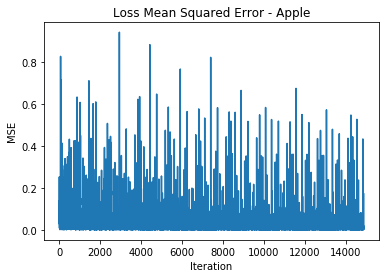

In [31]:
plt.figure()

plt.title("Loss Mean Squared Error - Apple")
plt.plot(np.arange(len(losses_aapl)), losses_aapl)
plt.ylabel("MSE")
plt.xlabel("Iteration")

plt.show()

Average MSE testing: 0.022571126520276114


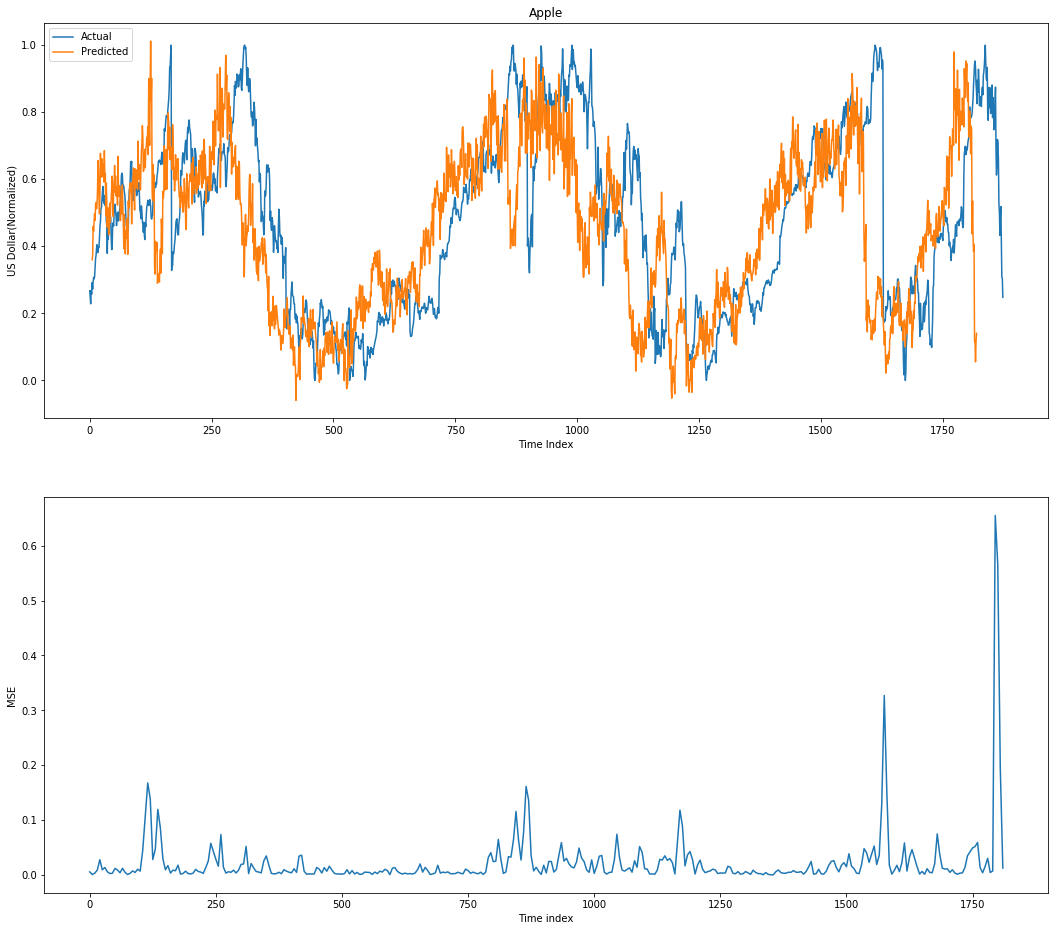

In [32]:
predictions_fix = []
for i in range(len(predictions_aapl)):
    for z in range(len(predictions_aapl[i])):
        predictions_fix.append(predictions_aapl[i][z][0])


plt.figure(figsize=(18, 16))

plt.subplot(211)
plt.title("Apple")

plt.plot(range(aapl_test.shape[0]), aapl_test[:,0], label = 'Actual')
plt.plot(range(hy_batch_size,len(predictions_fix)+hy_batch_size), predictions_fix, label="Predicted")
plt.legend()
plt.ylabel("US Dollar(Normalized)")
plt.xlabel("Time Index")

plt.subplot(212)
plt.plot(range(0, len(predictions_fix), hy_batch_size), losses_pred_aapl, label='Prediction Losses')
plt.xlabel("Time index")
plt.ylabel("MSE")

aapl_average_loss = sum(losses_pred_aapl)/(len(losses_pred_aapl))
print("Average MSE testing: " + str(aapl_average_loss))

plt.show()

In [ ]:
rnn_msft = LSTMStockPredictor(msft_train.shape[1], 
                              lstm_size=hy_lstm_size, 
                              batch_size=hy_batch_size, 
                              num_unrollings=hy_num_unrolling, 
                              learning_rate=hy_learning_rate, 
                              learning_rate_decay=hy_learning_rate_decay, 
                              init_epoch_decay=hy_init_epoch_decay)

losses_msft = rnn_msft.train(msft_train, num_epoch=10)

predictions_msft, losses_pred_msft = rnn_msft.predict(msft_test)

In [ ]:
plt.figure(figsize=(18, 16))

plt.title("Loss Mean Squared Error - Microsoft")
plt.plot(np.arange(len(losses_msft)), losses_msft)
plt.ylabel("MSE")
plt.xlabel("Iteration")

plt.show()

In [ ]:
predictions_fix = []
for i in range(len(predictions_msft)):
    for z in range(len(predictions_msft[i])):
        predictions_fix.append(predictions_msft[i][z][0])


plt.figure()

plt.subplot(211)
plt.title("Microsoft")

plt.plot(range(msft_test.shape[0]), msft_test[:,0], label = 'Actual')
plt.plot(range(hy_batch_size,len(predictions_fix)+hy_batch_size), predictions_fix, label="Predicted")
plt.legend()
plt.ylabel("US Dollar(Normalized)")
plt.xlabel("Time Index")

plt.subplot(212)
plt.plot(range(0, len(predictions_fix), hy_batch_size), losses_pred_msft, label='Prediction Losses')
plt.xlabel("Time index")
plt.ylabel("MSE")

msft_avg_loss = sum(losses_pred_msft)/(len(losses_pred_msft))
print("Average MSE testing: " + str(msft_avg_loss))

plt.show()